In [34]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle as pkl
import pandas as pd
import numpy as np
import random
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from de_ml_functions import prep_data, custom_train_test_split, train_models
import matplotlib.pyplot as plt
import seaborn as sns

# Re-run this block to see the distributions change

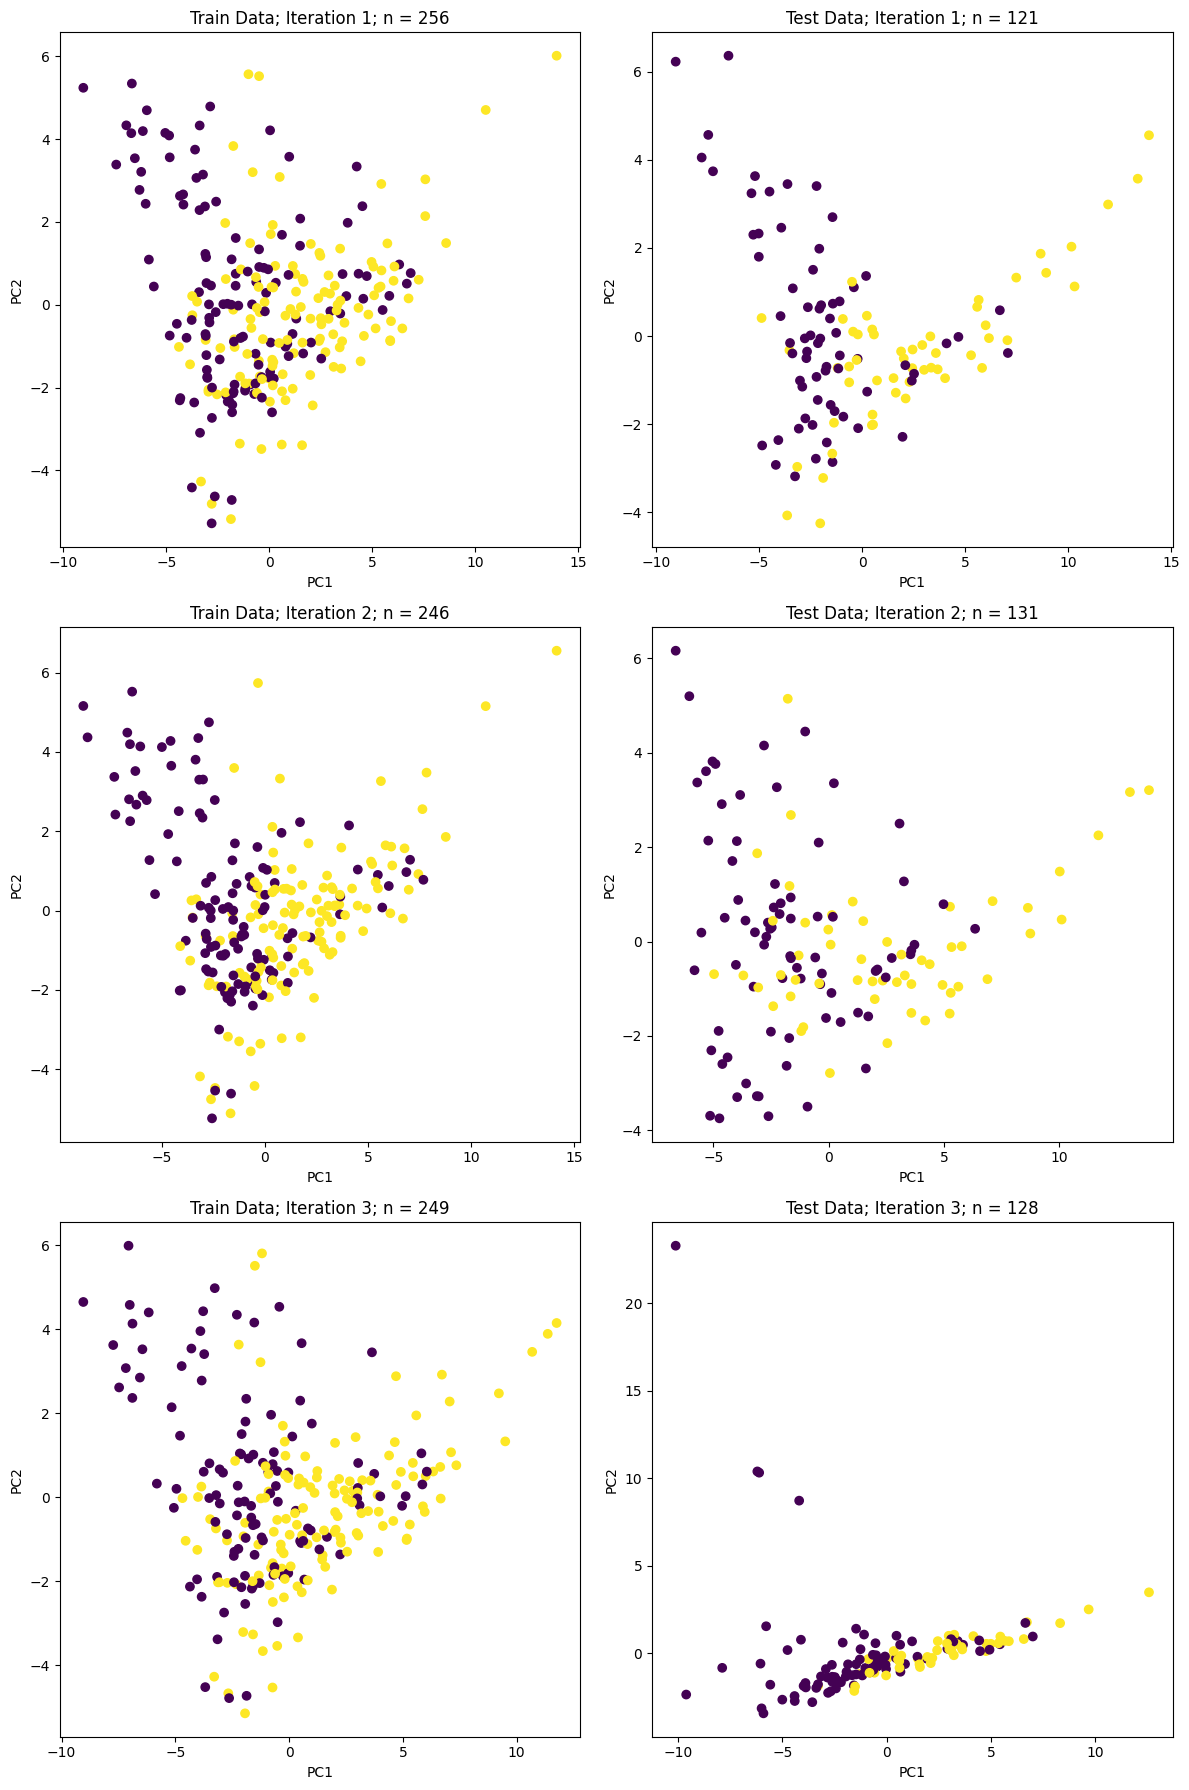

In [96]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data
ml_df, donor_ids, samples = prep_data()

# Prep PCA
pca = PCA(n_components=2, random_state=42)

# Set the size of the plots and create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 3 rows, 2 columns

for i in range(1, 4):
    X_train, y_train, X_test, y_test = custom_train_test_split(ml_df, donor_ids, samples)
    # Plot for Train Data
    X_train_pca = pca.fit_transform(X_train)
    axes[i - 1, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, label=y_train)
    axes[i - 1, 0].set_xlabel('PC1')
    axes[i - 1, 0].set_ylabel('PC2')
    axes[i - 1, 0].set_title(f'Train Data; Iteration {i}; n = {X_train.shape[0]}')

    # Plot for Test Data
    X_test_pca = pca.fit_transform(X_test)
    axes[i - 1, 1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, label=y_test)
    axes[i - 1, 1].set_xlabel('PC1')
    axes[i - 1, 1].set_ylabel('PC2')
    axes[i - 1, 1].set_title(f'Test Data; Iteration {i}; n = {X_test.shape[0]}')

    # fig.ax.spines['top'].set_visible(False)
    # fig.ax.spines['right'].set_visible(False)
# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()


## Logistic Regression

# Run this block to train the model on shuffled data (by donor id)

In [155]:
train_scores = []
test_scores = []
coefs = []
for i in range(1000):
    X_train, y_train, X_test, y_test = custom_train_test_split(ml_df,donor_ids, samples)
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, y_train)
    coefs.append(clf.coef_[0])

    preds = clf.predict(X_train)
    f1_score_train = f1_score(y_train,preds)
    train_scores.append(np.round(f1_score_train,4))

    preds = clf.predict(X_test)
    f1_score_test = f1_score(y_test,preds)
    test_scores.append(np.round(f1_score_test,4))

print('Training Logsitic Regession on Shuffled Donor IDs...')
print(f"After {i} iterations:")

print('First 3 scores...')
print('Train Scores (F1): ', train_scores[1:4])
print('Test Scores (F1): ', test_scores[1:4])

print('mean Train: ', np.round(np.mean(train_scores),4))
print('mean Test: ',np.round(np.mean(test_scores),4))

print('Training std : ', np.round(np.std(train_scores),4))
print('Testing std : ', np.round(np.std(test_scores),4))


Training Logsitic Regession on Shuffled Donor IDs...
After 999 iterations:
First 3 scores...
Train Scores (F1):  [0.8258, 0.8538, 0.787]
Test Scores (F1):  [0.7547, 0.5872, 0.6957]
mean Train:  0.8167
mean Test:  0.6818
Training std :  0.0293
Testing std :  0.0623


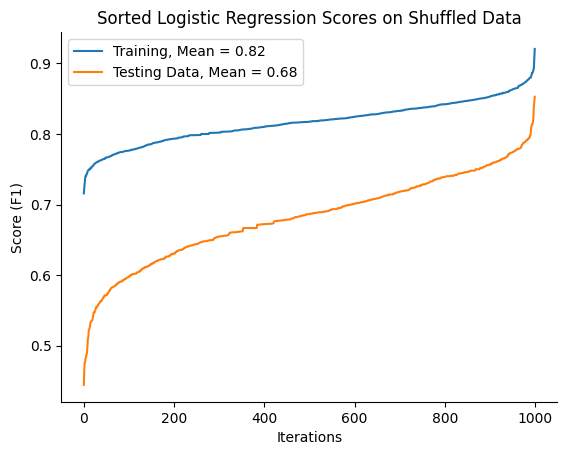

In [156]:
plt.plot(sorted(train_scores), label = f'Training, Mean = {np.round(np.mean(train_scores),2)}')
plt.plot(sorted(test_scores), label = f'Testing Data, Mean = {np.round(np.mean(test_scores),2)}')
plt.title('Sorted Logistic Regression Scores on Shuffled Data')
plt.ylabel('Score (F1)')
plt.xlabel('Iterations')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.axhline(np.mean(train_scores),color="gray",linestyle="--")
plt.legend()
plt.show()

In [157]:
# X = ml_df.drop(columns=['rnaseq_profile_id', 'Condition'])
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# y = ml_df['Condition'].apply(lambda x: 1 if x == 'dementia' else 0)


In [158]:
coefs_df = pd.DataFrame(coefs)
coefs_mean = coefs_df.T.mean(axis=1)
coefs_sem = coefs_df.T.sem(axis=1)

In [202]:
gene_data = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/rows-genes.csv')
gene_list = np.array(ml_df.set_index('rnaseq_profile_id').columns[:-1])

gene_ids_ranking = (
pd.DataFrame.from_dict({k:v for k,v in zip(gene_list, coefs_mean)}, orient = 'index', columns= ['coef'])
.rename_axis('gene_id')
.reset_index()
.sort_values(by='coef', ascending= False)
)

sort_order = np.argsort(coefs_mean.values)
descending_sort = sort_order[::-1]

gene_ids_ranking
gene_ids_ranking['sem'] = coefs_sem
gene_ids_ranking = gene_ids_ranking.merge(gene_data, on='gene_id')
gene_ids_ranking

,gene_id,coef,sem,chromosome,gene_entrez_id,gene_symbol,gene_name
0,499317231,0.788601,0.009540,4,4085,MAD2L1,MAD2 mitotic arrest deficient-like 1 (yeast)
1,499334626,0.571163,0.009561,12,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
2,499323096,0.502990,0.009952,7,79778,MICALL2,MICAL-like 2
3,499336992,0.419313,0.008776,12,5426,POLE,"polymerase (DNA directed), epsilon, catalytic ..."
4,499334295,0.417730,0.011505,11,283149,BCL9L,B-cell CLL/lymphoma 9-like
5,499343767,0.395385,0.007475,16,101927793,LOC101927793,uncharacterized LOC101927793
6,499329195,0.321150,0.010088,9,85301,COL27A1,"collagen, type XXVII, alpha 1"
7,499315843,0.246235,0.008928,4,285489,DOK7,docking protein 7
8,499352783,0.157208,0.007903,X,5475,PPEF1,"protein phosphatase, EF-hand calcium binding d..."
9,499322427,0.129810,0.007408,6,9729,KIAA0408,KIAA0408


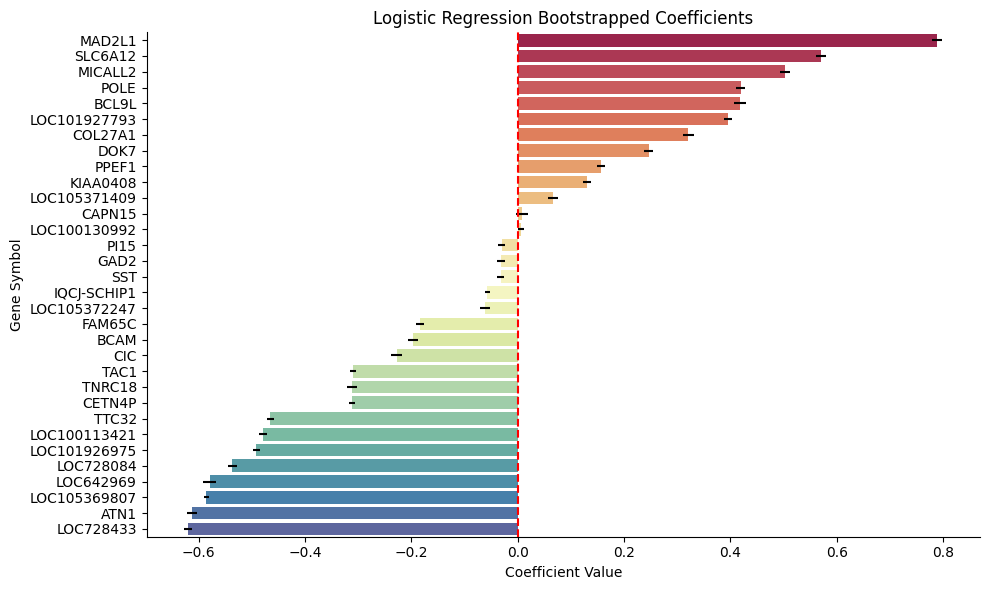

In [217]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='coef', y='gene_symbol', data=gene_ids_ranking, xerr=gene_ids_ranking['sem'], palette='Spectral')
plt.title('Logistic Regression Bootstrapped Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene Symbol')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(0,color="red",linestyle="--")
plt.tight_layout()
plt.show()

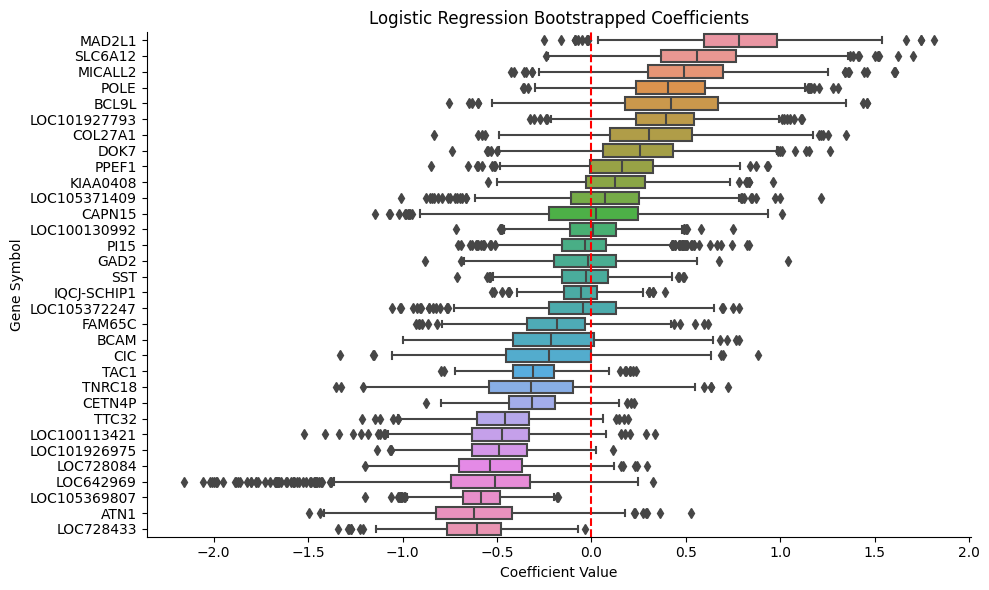

In [216]:
plt.figure(figsize=(10, 6))
sns.boxplot(coefs_df[descending_sort], orient= 'h',)
y_labels = gene_ids_ranking['gene_symbol']
plt.yticks(range(len(y_labels)), y_labels)
plt.title('Logistic Regression Bootstrapped Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene Symbol')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(0,color="red",linestyle="--")
plt.tight_layout()
plt.show()